# Machine Learning 2 - Assignment 1:

Taxi Cancellations Predictive Modeling Using Neural Networks

Group Members:
Alexandra Gladkova  
Christina Saju  
Hao Lun Rong  
Kushwant Sai Kolli  
Ladan Asempour


# Initialization

In [ ]:
!pip install geopy
!pip install dmba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 47.3 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow keras keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.1 MB/s eta 0:00:00


In [ ]:
# Cell for all imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score
from dmba import regressionSummary, classificationSummary, liftChart, gainsChart

# Necessary for calculating distance from latitude and longitude
# Reference: https://www.askpython.com/python/examples/find-distance-between-two-geo-locations
from geopy.distance import geodesic as GD

Colab environment detected.


In [ ]:
# Load data
df = pd.read_csv('Taxi-cancellation-case.csv')

# Gets the shape of the data
print(df.shape)

df #show all the data
#Confirms the data set is 10000 rows and 17 input columns
#1 output column (cancellation) as well as the "row #" are the remaining 2 columns

(10000, 19)


,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,1,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,41275.94,NaN,0,0,41275.33403,13.028530,77.546250,12.869805,77.653211,0
1,2,17037,12,NaN,2,455.0,1330.0,NaN,NaN,41275.53,NaN,0,0,41275.41597,12.999874,77.678120,12.953434,77.706510,0
2,3,761,12,NaN,2,814.0,393.0,NaN,NaN,41276.02,41277.00000,1,0,41275.50972,12.908993,77.688900,13.199560,77.706880,0
3,4,868,12,NaN,2,297.0,212.0,NaN,NaN,41275.55,NaN,0,0,41275.52917,12.997890,77.614880,12.994740,77.607970,0
4,5,21716,28,NaN,2,1237.0,330.0,NaN,NaN,41275.69,NaN,0,0,41275.62986,12.926450,77.612060,12.858833,77.589127,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,31877,12,2.0,3,293.0,NaN,NaN,NaN,41420.31,NaN,0,0,41419.76528,12.849482,77.663187,NaN,NaN,1
9996,9997,28305,12,1.0,3,1017.0,NaN,NaN,NaN,41519.55,41519.65354,1,0,41517.37014,13.110840,77.600740,NaN,NaN,0
9997,9998,24007,12,NaN,2,393.0,788.0,NaN,NaN,41306.07,NaN,0,0,41304.74792,13.199560,77.706880,12.924710,77.498670,0
9998,9999,33882,12,NaN,2,410.0,1026.0,NaN,NaN,41444.59,NaN,0,0,41439.43403,13.051210,77.541130,13.104820,77.576310,0


# Plot the overall cancellation rate

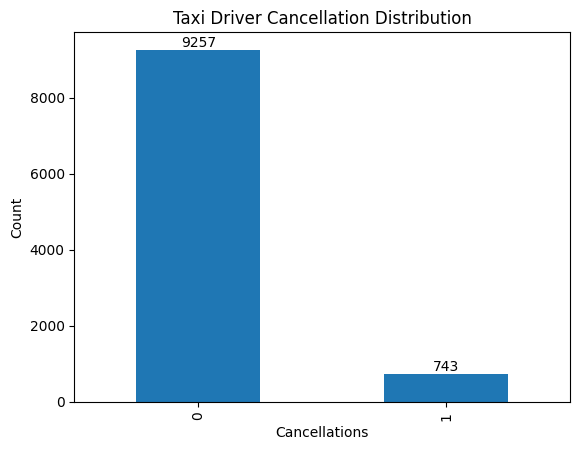

In [ ]:
# counting the type of cancellations
cancellations = df['Car_Cancellation'].value_counts()

# creating the plot with labels
df['Car_Cancellation'].value_counts().plot(kind='bar').bar_label(plt.gca().containers[0])
plt.xlabel("Cancellations")
plt.ylabel("Count")
plt.title("Taxi Driver Cancellation Distribution")

# Show the plot
plt.show()

# Examine distributions and relationships between key predictors and cancellations.


In [ ]:
# Checking the data type of each column
data_types = df.dtypes
data_types

,0
row#,int64
user_id,int64
vehicle_model_id,int64
package_id,float64
travel_type_id,int64
from_area_id,float64
to_area_id,float64
from_city_id,float64
to_city_id,float64
from_date,float64


In [ ]:
unique_values = df.nunique()

#Print the result
print(unique_values)

row#                   10000
user_id                 7044
vehicle_model_id          20
package_id                 7
travel_type_id             3
from_area_id             522
to_area_id               479
from_city_id               2
to_city_id                67
from_date               7976
to_date                 5407
online_booking             2
mobile_site_booking        2
booking_created         9611
from_lat                 422
from_long                419
to_lat                   390
to_long                  387
Car_Cancellation           2
dtype: int64


We will plot the data of each column vs the cancellations and see if we notice anything.


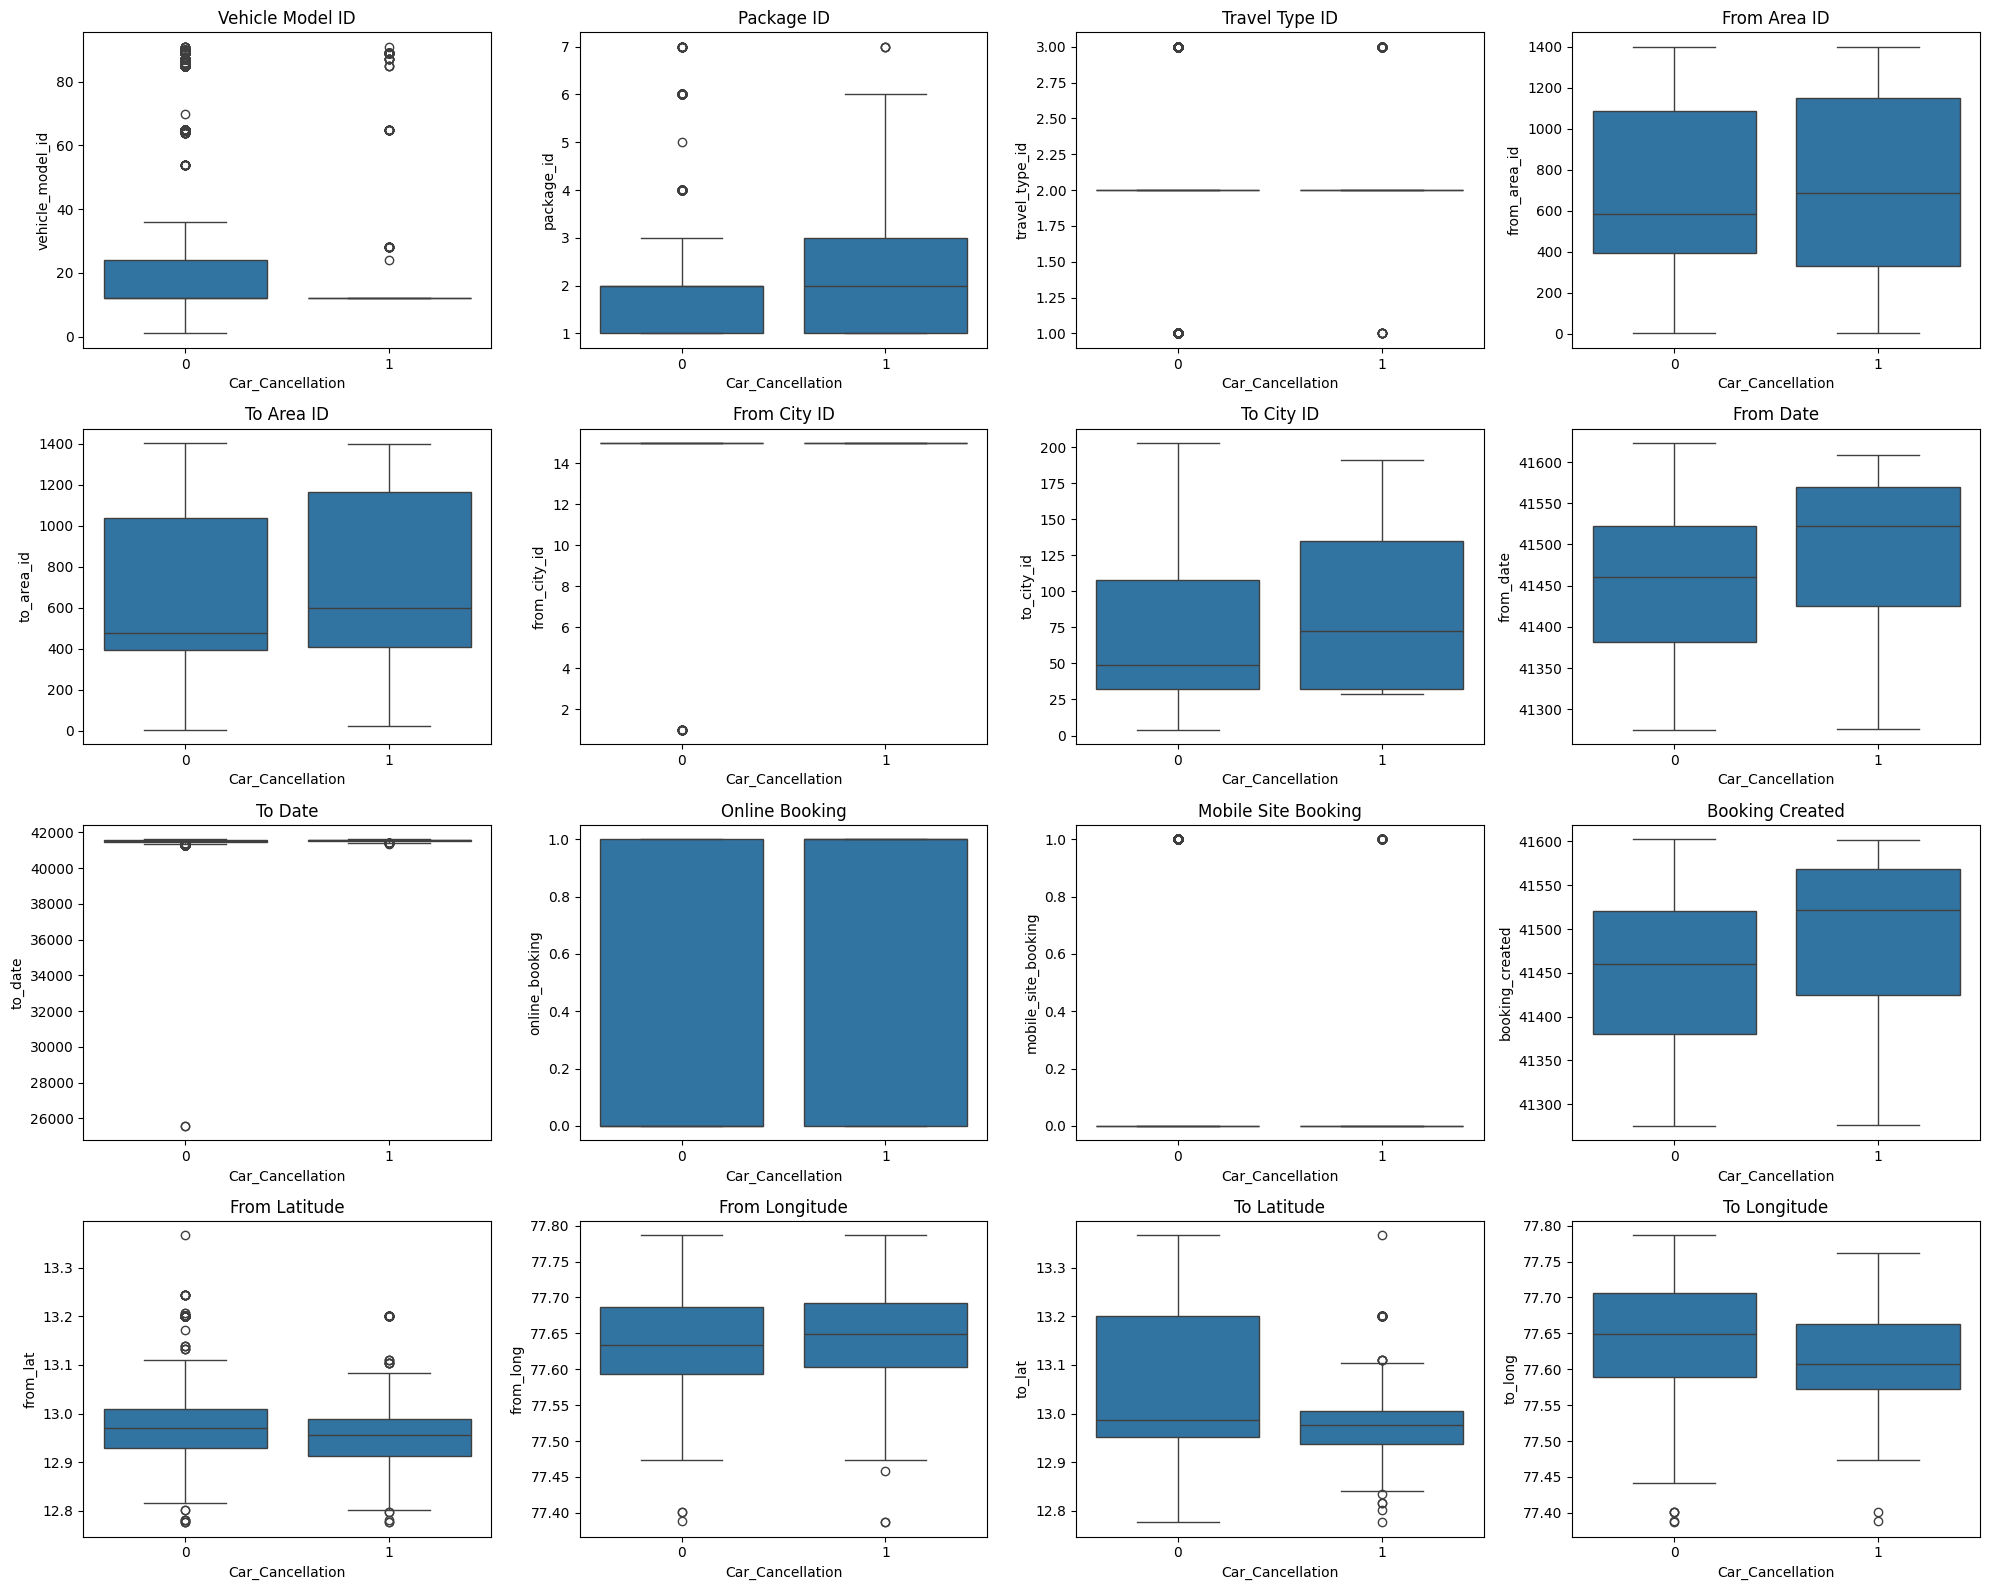

In [ ]:
# Listing all columns to plot
columns = ['vehicle_model_id', 'package_id', 'travel_type_id', 'from_area_id', 'to_area_id',
           'from_city_id', 'to_city_id', 'from_date', 'to_date', 'online_booking',
           'mobile_site_booking', 'booking_created', 'from_lat', 'from_long', 'to_lat', 'to_long']

# Defining rows and columns
num_columns = 4
num_rows = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 4))
axes = axes.flatten()

# Making boxplot for each figure
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'vehicle_model_id', ax = axes[0]).set_title('Vehicle Model ID')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'package_id', ax = axes[1]).set_title('Package ID')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'travel_type_id', ax = axes[2]).set_title('Travel Type ID')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'from_area_id', ax = axes[3]).set_title('From Area ID')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'to_area_id', ax = axes[4]).set_title('To Area ID')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'from_city_id', ax = axes[5]).set_title('From City ID')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'to_city_id', ax = axes[6]).set_title('To City ID')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'from_date', ax = axes[7]).set_title('From Date')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'to_date', ax = axes[8]).set_title('To Date')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'online_booking', ax = axes[9]).set_title('Online Booking')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'mobile_site_booking', ax = axes[10]).set_title('Mobile Site Booking')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'booking_created', ax = axes[11]).set_title('Booking Created')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'from_lat', ax = axes[12]).set_title('From Latitude')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'from_long', ax = axes[13]).set_title('From Longitude')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'to_lat', ax = axes[14]).set_title('To Latitude')
sns.boxplot(data = df, x = 'Car_Cancellation', y = 'to_long', ax = axes[15]).set_title('To Longitude')

plt.tight_layout()
plt.show()


While most of these do not show any clear trends, we can see that Vehicle type, Package ID, while we do not have the exact definitions for the codes, we can speculate what these are in the conclusions.

# Handle missing values appropriately.

In [ ]:
# Counts the number of entries where value is null for each row
missing_data = df.isnull().sum()

# Calculate percentage of missing values
missing_data_percent = (missing_data / len(df)) * 100

# Shows each column and the percentage of missing values there are
missing_data_percent

,0
row#,0.00
user_id,0.00
vehicle_model_id,0.00
package_id,82.48
travel_type_id,0.00
from_area_id,0.15
to_area_id,20.91
from_city_id,62.94
to_city_id,96.61
from_date,0.00


Since there are a large portion of missing values specifically in some columns, but smaller percentages in others, we will address the data column by column.

'package_id' will be removed completely as over 80% of the data is missing.

the from and to city_id columns have 62% and 96% data of their data missing respectively. however the area_id columns serve a similar purpose so we still have meaningful location data.

from_date and to_date likely have similar days as taxi rides typically do not last more than an hour or two, we can keep the from_date and remove to_date as to not lose too many rows due to cleaning.

We will also remove the row# and user_id columns as they provide no value to our analysis

In [ ]:
# Dropping above columns with significant null values
# Dropping these columns instead of removing nulls will retain more data
df = df.drop(columns=['package_id', 'booking_created', 'from_city_id', 'to_city_id', 'to_date', 'row#', 'user_id','from_area_id','to_area_id'])

# printing shape of data again
print(df.shape)

(10000, 10)


In [ ]:
df

,vehicle_model_id,travel_type_id,from_date,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,12,2,41275.94,0,0,13.028530,77.546250,12.869805,77.653211,0
1,12,2,41275.53,0,0,12.999874,77.678120,12.953434,77.706510,0
2,12,2,41276.02,1,0,12.908993,77.688900,13.199560,77.706880,0
3,12,2,41275.55,0,0,12.997890,77.614880,12.994740,77.607970,0
4,28,2,41275.69,0,0,12.926450,77.612060,12.858833,77.589127,0
...,...,...,...,...,...,...,...,...,...,...
9995,12,3,41420.31,0,0,12.849482,77.663187,NaN,NaN,1
9996,12,3,41519.55,1,0,13.110840,77.600740,NaN,NaN,0
9997,12,2,41306.07,0,0,13.199560,77.706880,12.924710,77.498670,0
9998,12,2,41444.59,0,0,13.051210,77.541130,13.104820,77.576310,0


# Geographical data

In [ ]:
# Remove rows with null values in specific columns
df_cleaned = df.dropna(subset=['from_lat', 'from_long', 'to_lat', 'to_long'])

# Display the cleaned DataFrame
print(df_cleaned)

      vehicle_model_id  travel_type_id  from_date  online_booking  \
0                   12               2   41275.94               0   
1                   12               2   41275.53               0   
2                   12               2   41276.02               1   
3                   12               2   41275.55               0   
4                   28               2   41275.69               0   
...                ...             ...        ...             ...   
9992                12               2   41535.69               0   
9993                85               2   41559.84               1   
9994                12               2   41506.95               0   
9997                12               2   41306.07               0   
9998                12               2   41444.59               0   

      mobile_site_booking   from_lat  from_long     to_lat    to_long  \
0                       0  13.028530  77.546250  12.869805  77.653211   
1                       0

In [ ]:
from geopy.distance import geodesic

# Define a function to calculate the distance
def calculate_distance(row):
    start_coords = (row['from_lat'], row['from_long'])
    end_coords = (row['to_lat'], row['to_long'])
    return geodesic(start_coords, end_coords).kilometers

# Apply the function to the DataFrame
df_cleaned['distance_km'] = df_cleaned.apply(calculate_distance, axis=1)

# Display the first few rows with the new distance column
print(df_cleaned[['from_lat', 'from_long', 'to_lat', 'to_long', 'distance_km']].head())


    from_lat  from_long     to_lat    to_long  distance_km
0  13.028530   77.54625  12.869805  77.653211    21.048611
1  12.999874   77.67812  12.953434  77.706510     5.990251
2  12.908993   77.68890  13.199560  77.706880    32.204802
3  12.997890   77.61488  12.994740  77.607970     0.826682
4  12.926450   77.61206  12.858833  77.589127     7.883644


<ipython-input-16-eb794abcbf03>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['distance_km'] = df_cleaned.apply(calculate_distance, axis=1)


<ipython-input-17-c9c0f17c7e4a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cluster'] = kmeans.fit_predict(coordinates)


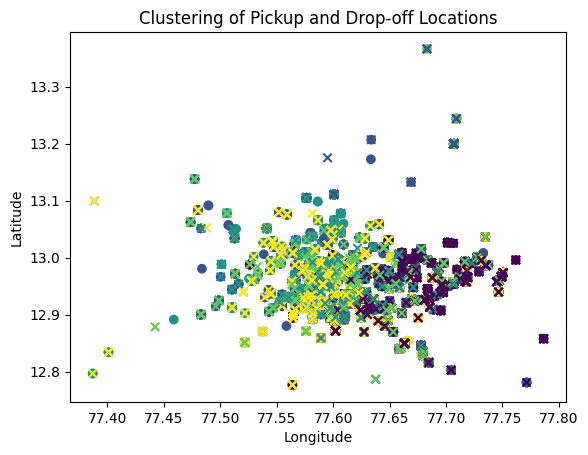

In [ ]:
from sklearn.cluster import KMeans

# Consider both pickup and drop-off locations for clustering
coordinates = df_cleaned[['from_lat', 'from_long', 'to_lat', 'to_long']]

# Perform KMeans clustering (you can change the number of clusters as needed)
kmeans = KMeans(n_clusters=5, random_state=42)
df_cleaned['cluster'] = kmeans.fit_predict(coordinates)

# Plot the clusters on a map (using the first 2 dimensions for visualization)
plt.scatter(df_cleaned['from_long'], df_cleaned['from_lat'], c=df_cleaned['cluster'], cmap='viridis')
plt.scatter(df_cleaned['to_long'], df_cleaned['to_lat'], c=df_cleaned['cluster'], cmap='viridis', marker='x')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustering of Pickup and Drop-off Locations')
plt.show()


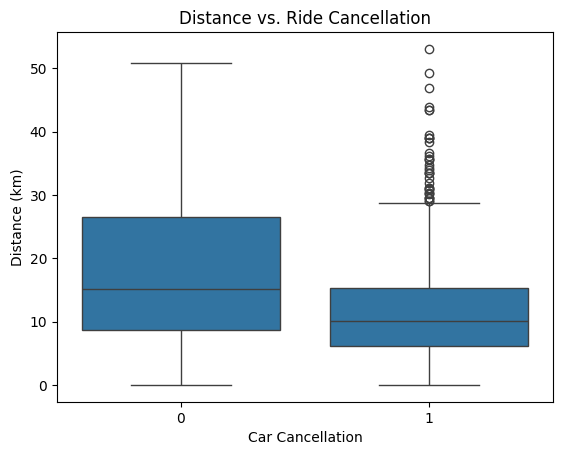

In [ ]:
# Compare distance against cancellation status (0 for not cancelled, 1 for cancelled)
sns.boxplot(data=df_cleaned, x='Car_Cancellation', y='distance_km')
plt.title('Distance vs. Ride Cancellation')
plt.xlabel('Car Cancellation')
plt.ylabel('Distance (km)')
plt.show()


<ipython-input-19-082a37ed166a>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=df_cleaned['from_long'], y=df_cleaned['from_lat'], cmap='Blues', fill=True, shade=True, thresh=0.05)
<ipython-input-19-082a37ed166a>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=df_cleaned['to_long'], y=df_cleaned['to_lat'], cmap='Reds', fill=True, shade=True, thresh=0.05)


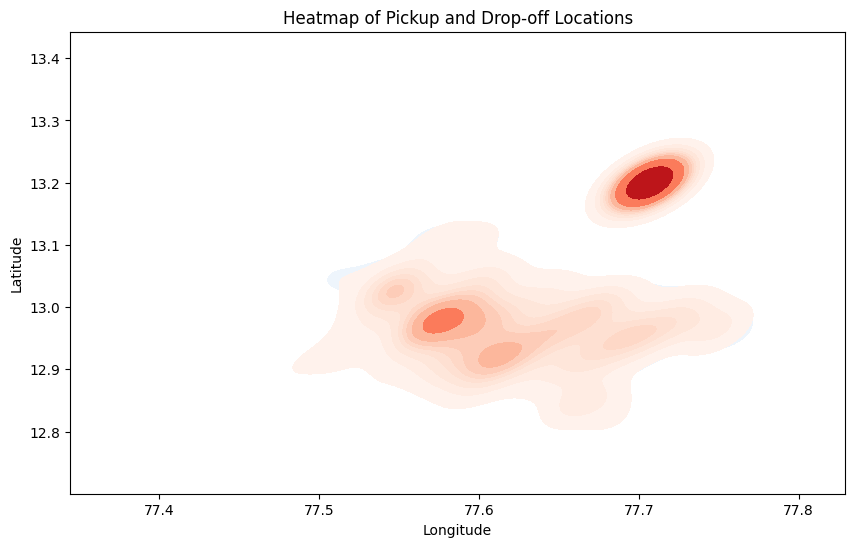

In [ ]:
import seaborn as sns

# Create a heatmap of pickup and drop-off locations
plt.figure(figsize=(10, 6))
sns.kdeplot(x=df_cleaned['from_long'], y=df_cleaned['from_lat'], cmap='Blues', fill=True, shade=True, thresh=0.05)
sns.kdeplot(x=df_cleaned['to_long'], y=df_cleaned['to_lat'], cmap='Reds', fill=True, shade=True, thresh=0.05)
plt.title('Heatmap of Pickup and Drop-off Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Overall while we have created some findings from the distance, such as longer trips show a likelihood of being cancelled more often, we decided to not use geographical data as distance does not accurately represent real road routes since it was calculated for a straight line distance.

In [ ]:
# Dropping location data from original dataset since we are no longer using it.
df = df.drop(columns=['from_lat', 'from_long', 'to_lat', 'to_long'])

df.head()

,vehicle_model_id,travel_type_id,from_date,online_booking,mobile_site_booking,Car_Cancellation
0,12,2,41275.94,0,0,0
1,12,2,41275.53,0,0,0
2,12,2,41276.02,1,0,0
3,12,2,41275.55,0,0,0
4,28,2,41275.69,0,0,0


# Extract useful features from timestamps

In [ ]:
df['from_date'] = df['from_date'].astype(float).astype(int)
df['from_date_tran'] = pd.to_datetime(df['from_date'], origin='1899-12-30', unit='D')

In [ ]:
df['from_date_Year'] = df['from_date_tran'].dt.year
df['from_date_Month'] = df['from_date_tran'].dt.month
df['from_date_Day'] = df['from_date_tran'].dt.day

df.drop(columns=['from_date_tran'], inplace=True)

In [ ]:
df.head()

,vehicle_model_id,travel_type_id,from_date,online_booking,mobile_site_booking,Car_Cancellation,from_date_Year,from_date_Month,from_date_Day
0,12,2,41275,0,0,0,2013,1,1
1,12,2,41275,0,0,0,2013,1,1
2,12,2,41276,1,0,0,2013,1,2
3,12,2,41275,0,0,0,2013,1,1
4,28,2,41275,0,0,0,2013,1,1


# Encode categorical variables (e.g., booking type, travel type) using one-hot
encoding or other methods. Normalize or standardize numerical features if
necessary.

From the remaining inputs, vehicle_model_id as well as travel_type_id can be one hot encoded to create dummies for each type.

In [ ]:
a = df['travel_type_id'].unique()
print(a)

[2 3 1]


In [ ]:
dv_vehicle = pd.get_dummies(df['vehicle_model_id'], prefix='vehicle_model_id')
dv_travel_type = pd.get_dummies(df['travel_type_id'], prefix='travel_type_id')

# Appending more data onto the df_dummies table
df = pd.concat([df, dv_vehicle, dv_travel_type], axis=1)

# dropping the original columns after
df = df.drop(columns=['vehicle_model_id', 'travel_type_id'])

#changing the dummy variables to binary interger
df.replace({False: 0, True: 1}, inplace=True)

<ipython-input-25-76a9a818b1d9>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({False: 0, True: 1}, inplace=True)


In [ ]:
df.head()

,from_date,online_booking,mobile_site_booking,Car_Cancellation,from_date_Year,from_date_Month,from_date_Day,vehicle_model_id_1,vehicle_model_id_10,vehicle_model_id_12,...,vehicle_model_id_70,vehicle_model_id_85,vehicle_model_id_86,vehicle_model_id_87,vehicle_model_id_89,vehicle_model_id_90,vehicle_model_id_91,travel_type_id_1,travel_type_id_2,travel_type_id_3
0,41275,0,0,0,2013,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,41275,0,0,0,2013,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,41276,1,0,0,2013,1,2,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,41275,0,0,0,2013,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,41275,0,0,0,2013,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
a = df['from_date_Year'].unique()
b = df['from_date_Month'].unique()
c = df['from_date_Day'].unique()

print(a)
print(b)
print(c)

df = df.drop(columns=['from_date', 'from_date_Year'])

[2013]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2 24  3  5  4  7  6 25  9  8 11 10 12 26 13 14 28 15 16 17 18 19 20
 29 30 21 22 23 27 31]


Since we only have one year (2013), we will not the Year variable as a predictor in our predictive model.

# KerasTuner

In [ ]:
#This script uses KerasTuner to optimize a neural network for predicting taxi cancellations.  It dynamically searches for the best number of hidden layers (1-3) and neurons per layer (16-128) to maximize validation accuracy.The best model configuration is selected automatically.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()

    # Input Layer
    model.add(keras.layers.InputLayer(input_shape=(df.shape[1] - 1,)))  # Excluding target column

    # Hidden Layers - Tune the number and size
    for i in range(hp.Int("num_layers", 1, 3)):  # Search between 1 to 3 hidden layers
        model.add(keras.layers.Dense(
            units=hp.Int(f"units_{i}", min_value=16, max_value=128, step=16),
            activation="relu"
        ))

    # Output Layer
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

# KerasTuner Hyperparameter Search
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",  # Objective is validation accuracy
    max_trials=10,  # Trying 10 different architectures
    executions_per_trial=1,
    directory="tuner_results",
    project_name="taxi_cancellation_nn"
)

# Extract features and target
X = df.drop(columns=['Car_Cancellation'])  # Features
y = df['Car_Cancellation']  # Target

# Perform search
tuner.search(X, y, epochs=10, validation_split=0.2)  # Splitting for validation

# Get the best hyperparameters from KerasTuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Display the best hyperparameters
print("Best Hyperparameters:")
print(f"Best Number of Hidden Layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Layer {i+1}: {best_hps.get(f'units_{i}')} neurons")

# Display the model architecture
print("\nBest Model Architecture:")
best_model.summary()

# Retrain the best model on the full dataset
best_model.fit(X, y, epochs=10, validation_split=0.2)  # Optionally, use a separate test dataset

# Evaluate the best model on the validation set (or test set if you have it)
val_accuracy = best_model.evaluate(X, y)  # You can pass a separate validation or test set

# Display the final validation accuracy
print(f"\nFinal Model Validation Accuracy: {val_accuracy[1]}")


Trial 7 Complete [00h 00m 15s]
val_accuracy: 0.8504999876022339

Best val_accuracy So Far: 0.8504999876022339
Total elapsed time: 00h 01m 37s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
1                 |2                 |num_layers
16                |16                |units_0
112               |16                |units_1
112               |None              |units_2

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6199 - loss: 0.7643 - val_accuracy: 0.8505 - val_loss: 0.5554
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9439 - loss: 0.2207 - val_accuracy: 0.8505 - val_loss: 0.5120
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9449 - loss: 0.2091 - val_accuracy: 0.8505 - val_loss: 0.5267
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9444 - loss: 0.2039 - val_accuracy: 0.8505 - val_loss: 0.5082
Epoch 5/10
 81/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9409 - loss: 0.2105

KeyboardInterrupt: 

KerasTuner performs a random search over different neural network configurations, so the results may vary with each run. The number of hidden layers and neurons can change due to the stochastic nature of the tuning process

#Train and Test split

In [ ]:
# Creating a train and test split for cancellation prediction
# Defining what predictors you will use to predict cancellation
can_predictors = df.drop(columns=['Car_Cancellation']).columns
can_outcome = 'Car_Cancellation'

# Partition data into predictors (x) and output (y)
X = df[can_predictors]
y = df[can_outcome]

# Split the data into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=1)

# Neural network model

In [ ]:
# The best model from above is selected
model = best_model
# Step 6: Train the model
# Training on 80% of the data and validating on 20% of the training set.
history = model.fit(train_X, train_y, validation_split=0.2, epochs=50, batch_size=10, verbose=1)

# Step 7: Evaluate the model on the test set
# Accuracy gives a quick measure of overall performance.
loss, accuracy = model.evaluate(valid_X, valid_y, verbose=0)
print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


640/640 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8758 - loss: 0.3645 - val_accuracy: 0.9250 - val_loss: 0.2657
Epoch 2/35
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9306 - loss: 0.2455 - val_accuracy: 0.9250 - val_loss: 0.2492
Epoch 3/35
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9224 - loss: 0.2527 - val_accuracy: 0.9250 - val_loss: 0.2454
Epoch 4/35
640/640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9202 - loss: 0.2491 - val_accuracy: 0.9250 - val_loss: 0.2440
Epoch 5/35
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9234 - loss: 0.2417 - val_accuracy: 0.9250 - val_loss: 0.2405
Epoch 6/35
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9226 - loss: 0.2430 - val_accuracy: 0.9250 - val_loss: 0.2513
Epoch 7/35
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9263 - loss: 0.2396 - val_accuracy: 0.9250 - val_loss: 0.2418
Epoch 8/35
640/640 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9267 - loss: 0.2244 - val_accuracy: 0.9250 - val_

In [ ]:
# Step 8: Predict probabilities on the test set
# `predict` returns probabilities for each class.
y_pred_probs = model.predict(valid_X)
y_pred_classes = y_pred_probs.argmax(axis=1)  # Convert probabilities to predicted classes

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Step 9: Confusion Matrix
# Confusion matrix shows how well the model distinguishes between classes.
conf_matrix = confusion_matrix(valid_y, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[1860    0]
 [ 140    0]]


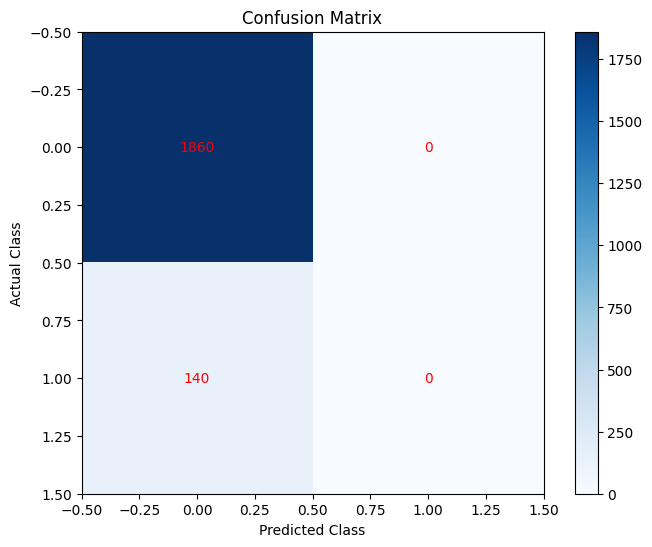

In [ ]:
# Visualization of confusion matrix for better interpretation
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='red')
plt.show()

In [ ]:
# Step 10: Classification Report
# Provides precision, recall, F1-score, and support for each class.
print('Classification Report:')
print(classification_report(valid_y, y_pred_classes))

In [ ]:
#Feature Importance using SHAP Values
# Explain the model predictions using SHAP values
import shap
explainer = shap.Explainer(model, train_X)
shap_values = explainer(train_X)

# Summary plot of feature importance
shap.summary_plot(shap_values, train_X)


In [ ]:
# Sorting probabilities and actual values
df_lift = pd.DataFrame({'probabilities': y_pred_probs.ravel(), 'actual': valid_y.ravel()})
df_lift = df_lift.sort_values(by='probabilities', ascending=False)

# Lift chart visualization
plt.figure(figsize=(8, 6))

df_lift['actual'] = pd.to_numeric(df_lift['actual'])

liftChart(df_lift['actual'], title='Lift Chart for Car Cancellation Prediction')

plt.show()